Using device: cpu
Model parameters: 1341
Epoch 100/5000, Loss: 0.227991, IC Loss: 0.148057, BC Loss: 0.069497, PDE Loss: 0.010437, Time: 1.71s
Epoch 200/5000, Loss: 0.123046, IC Loss: 0.077573, BC Loss: 0.042781, PDE Loss: 0.002691, Time: 3.53s
Epoch 300/5000, Loss: 0.077678, IC Loss: 0.048996, BC Loss: 0.021340, PDE Loss: 0.007341, Time: 5.57s
Epoch 400/5000, Loss: 0.033619, IC Loss: 0.019137, BC Loss: 0.006697, PDE Loss: 0.007786, Time: 8.18s
Epoch 500/5000, Loss: 0.013552, IC Loss: 0.005905, BC Loss: 0.002132, PDE Loss: 0.005514, Time: 10.44s
Epoch 600/5000, Loss: 0.007806, IC Loss: 0.002402, BC Loss: 0.001172, PDE Loss: 0.004233, Time: 12.10s
Epoch 700/5000, Loss: 0.004970, IC Loss: 0.001198, BC Loss: 0.000793, PDE Loss: 0.002979, Time: 13.76s
Epoch 800/5000, Loss: 0.003374, IC Loss: 0.000655, BC Loss: 0.000595, PDE Loss: 0.002123, Time: 15.41s
Epoch 900/5000, Loss: 0.002464, IC Loss: 0.000382, BC Loss: 0.000472, PDE Loss: 0.001611, Time: 17.08s
Epoch 1000/5000, Loss: 0.001901, IC 

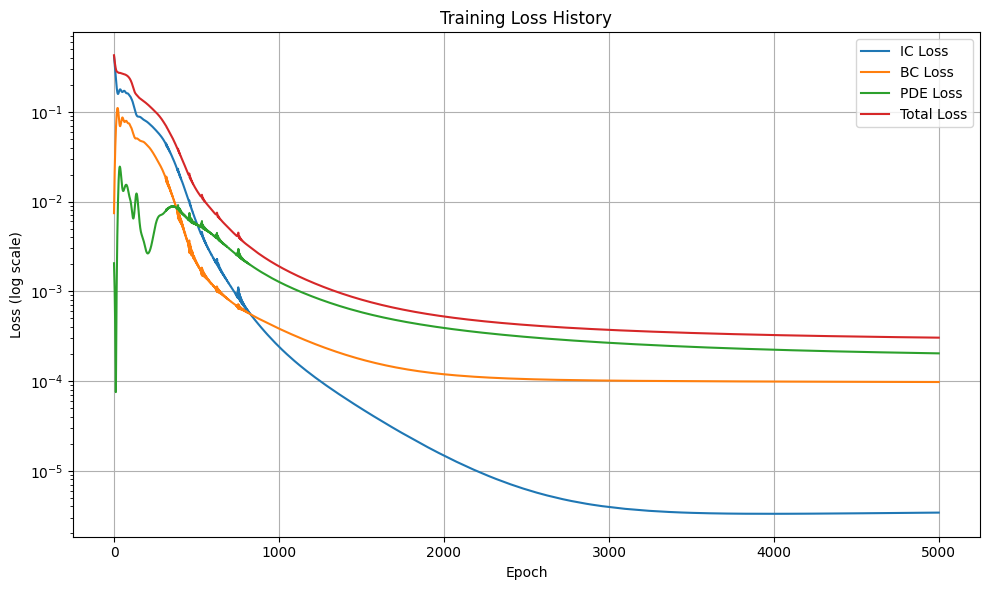

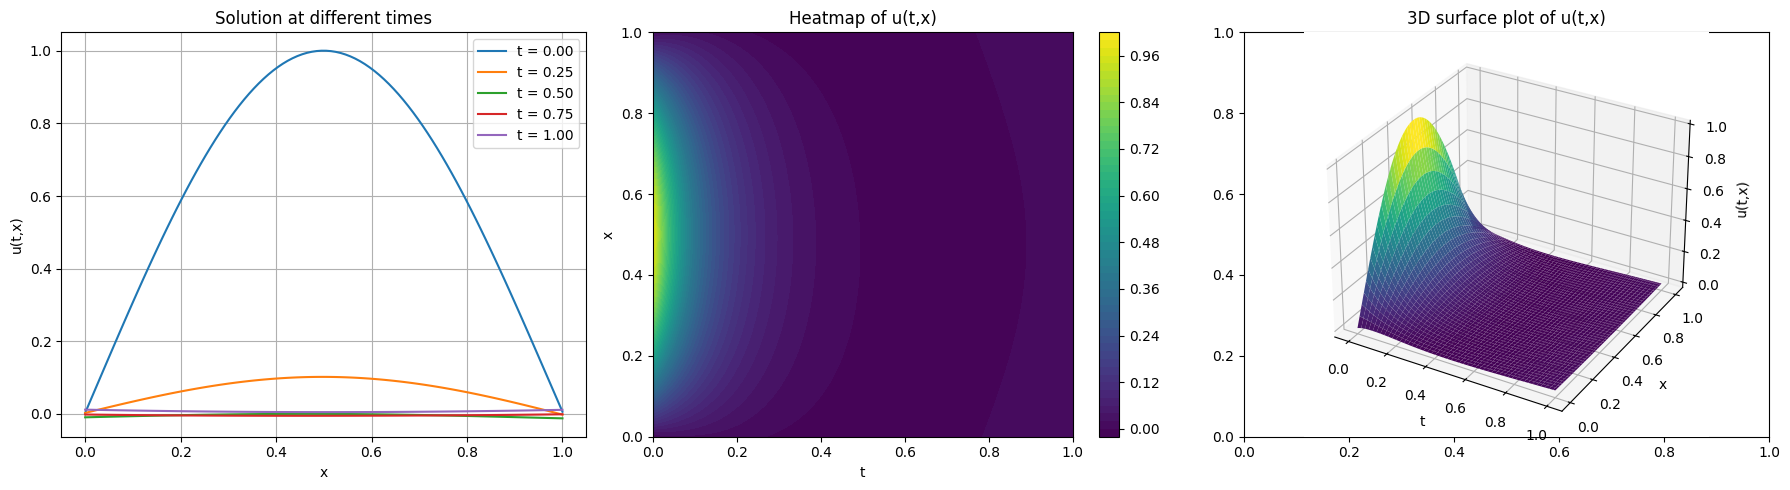

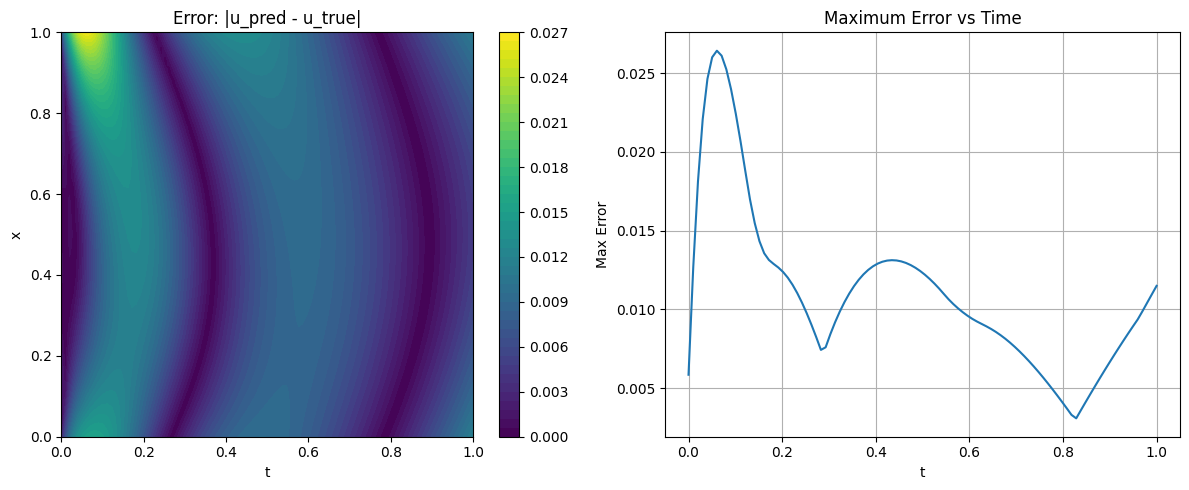

Generated 100 sampled points for the inverse problem
Forward problem completed successfully!


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

# Set random seed for reproducibility
torch.manual_seed(1234)
np.random.seed(1234)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class PINN(nn.Module):
    def __init__(self, hidden_layers, neurons_per_layer):
        super(PINN, self).__init__()
        
        # Input layer: (t, x) -> first hidden layer
        layers = [nn.Linear(2, neurons_per_layer), nn.Tanh()]
        
        # Hidden layers
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(neurons_per_layer, neurons_per_layer))
            layers.append(nn.Tanh())
        
        # Output layer: last hidden layer -> u(t,x)
        layers.append(nn.Linear(neurons_per_layer, 1))
        
        # Combine all layers
        self.net = nn.Sequential(*layers)
    
    def forward(self, t, x):
        # Stack t and x to create input tensor
        inputs = torch.cat([t, x], dim=1)
        return self.net(inputs)

def generate_training_data(n_ic, n_bc, n_collocation):
    """
    Generate training data:
    - Initial condition points: t=0, x∈[0,1]
    - Boundary condition points: x=0 or x=1, t∈[0,1]
    - Collocation points: random (t,x) ∈ [0,1]×[0,1]
    """
    # Initial condition points: t=0, x∈[0,1]
    t_ic = torch.zeros(n_ic, 1, device=device)
    x_ic = torch.linspace(0, 1, n_ic, device=device).reshape(-1, 1)
    u_ic = torch.sin(np.pi * x_ic)  # u(0,x) = sin(πx)
    
    # Boundary condition points: x=0 or x=1, t∈[0,1]
    # Left boundary: x=0
    t_bc_left = torch.linspace(0, 1, n_bc//2, device=device).reshape(-1, 1)
    x_bc_left = torch.zeros(n_bc//2, 1, device=device)
    u_bc_left = torch.zeros(n_bc//2, 1, device=device)  # u(t,0) = 0
    
    # Right boundary: x=1
    t_bc_right = torch.linspace(0, 1, n_bc//2, device=device).reshape(-1, 1)
    x_bc_right = torch.ones(n_bc//2, 1, device=device)
    u_bc_right = torch.zeros(n_bc//2, 1, device=device)  # u(t,1) = 0
    
    # Combine boundary points
    t_bc = torch.cat([t_bc_left, t_bc_right], dim=0)
    x_bc = torch.cat([x_bc_left, x_bc_right], dim=0)
    u_bc = torch.cat([u_bc_left, u_bc_right], dim=0)
    
    # Collocation points: random (t,x) ∈ [0,1]×[0,1]
    t_collocation = torch.rand(n_collocation, 1, device=device)
    x_collocation = torch.rand(n_collocation, 1, device=device)
    
    return t_ic, x_ic, u_ic, t_bc, x_bc, u_bc, t_collocation, x_collocation

def compute_pde_residual(model, t, x, kappa=1.0):
    """
    Compute the residual of the PDE: u_t - (κ(x) * u_x)_x = 0
    For the forward problem, κ(x) = 1 (constant)
    """
    # Create variables that require gradient
    t = t.clone().detach().requires_grad_(True)
    x = x.clone().detach().requires_grad_(True)
    
    # Forward pass to get u(t,x)
    u = model(t, x)
    
    # Compute derivatives using automatic differentiation
    u_t = torch.autograd.grad(
        u, t, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]
    
    u_x = torch.autograd.grad(
        u, x, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]
    
    # For constant κ(x) = 1, we can directly compute u_xx
    u_xx = torch.autograd.grad(
        u_x, x,
        grad_outputs=torch.ones_like(u_x),
        retain_graph=True,
        create_graph=True
    )[0]
    
    # PDE residual: u_t - (κ(x) * u_x)_x = u_t - κ(x) * u_xx = 0
    # For κ(x) = 1, this simplifies to: u_t - u_xx = 0
    pde_residual = u_t - kappa * u_xx
    
    return pde_residual

def train_pinn(model, optimizer, scheduler, n_ic, n_bc, n_collocation, n_epochs, lambda_ic=1.0, lambda_bc=1.0, lambda_pde=1.0):
    """
    Train the PINN
    """
    # Track losses
    ic_losses = []
    bc_losses = []
    pde_losses = []
    total_losses = []
    
    # Generate training data
    t_ic, x_ic, u_ic, t_bc, x_bc, u_bc, t_collocation, x_collocation = generate_training_data(n_ic, n_bc, n_collocation)
    
    # Start training
    start_time = time.time()
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        
        # Initial condition loss
        u_ic_pred = model(t_ic, x_ic)
        loss_ic = torch.mean((u_ic - u_ic_pred) ** 2)
        
        # Boundary condition loss
        u_bc_pred = model(t_bc, x_bc)
        loss_bc = torch.mean((u_bc - u_bc_pred) ** 2)
        
        # PDE residual loss
        pde_residual = compute_pde_residual(model, t_collocation, x_collocation)
        loss_pde = torch.mean(pde_residual ** 2)
        
        # Total loss
        loss = lambda_ic * loss_ic + lambda_bc * loss_bc + lambda_pde * loss_pde
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        # Update learning rate
        if scheduler is not None:
            scheduler.step()
        
        # Store losses
        ic_losses.append(loss_ic.item())
        bc_losses.append(loss_bc.item())
        pde_losses.append(loss_pde.item())
        total_losses.append(loss.item())
        
        # Print progress
        if (epoch + 1) % 100 == 0:
            elapsed = time.time() - start_time
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.6f}, IC Loss: {loss_ic.item():.6f}, "
                  f"BC Loss: {loss_bc.item():.6f}, PDE Loss: {loss_pde.item():.6f}, Time: {elapsed:.2f}s")
    
    # Final time
    total_time = time.time() - start_time
    print(f"Training completed in {total_time:.2f} seconds")
    
    return ic_losses, bc_losses, pde_losses, total_losses

def visualize_results(model, n_x=100, n_t=100):
    """
    Visualize the results of the trained PINN
    """
    # Create a grid of points
    x = torch.linspace(0, 1, n_x, device=device).reshape(-1, 1)
    t = torch.linspace(0, 1, n_t, device=device).reshape(-1, 1)
    X, T = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='ij')
    X_flat = X.reshape(-1, 1)
    T_flat = T.reshape(-1, 1)
    
    # Predict u(t,x)
    with torch.no_grad():
        U_flat = model(T_flat, X_flat)
    U = U_flat.reshape(n_x, n_t).cpu().numpy()
    
    # Plot the solution
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot u(t,x) at different times
    times = [0, 0.25, 0.5, 0.75, 1.0]
    for t_val in times:
        t_idx = int(t_val * (n_t - 1))
        axs[0].plot(x.cpu().numpy(), U[:, t_idx], label=f"t = {t_val:.2f}")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("u(t,x)")
    axs[0].set_title("Solution at different times")
    axs[0].legend()
    axs[0].grid(True)
    
    # Heatmap of u(t,x)
    im = axs[1].contourf(T.cpu().numpy(), X.cpu().numpy(), U, levels=50, cmap='viridis')
    axs[1].set_xlabel("t")
    axs[1].set_ylabel("x")
    axs[1].set_title("Heatmap of u(t,x)")
    plt.colorbar(im, ax=axs[1])
    
    # 3D surface plot
    X_np, T_np = X.cpu().numpy(), T.cpu().numpy()
    ax = axs[2] = plt.subplot(1, 3, 3, projection='3d')
    surf = ax.plot_surface(T_np, X_np, U, cmap='viridis', edgecolor='none')
    ax.set_xlabel("t")
    ax.set_ylabel("x")
    ax.set_zlabel("u(t,x)")
    ax.set_title("3D surface plot of u(t,x)")
    
    plt.tight_layout()
    plt.show()
    
    # Compare with analytical solution if possible
    # For heat equation with κ=1, u(0,x) = sin(πx), u(t,0) = u(t,1) = 0
    # The analytical solution is u(t,x) = exp(-π²t) * sin(πx)
    X_grid, T_grid = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='ij')
    analytical_solution = torch.exp(-np.pi**2 * T_grid) * torch.sin(np.pi * X_grid)
    analytical_solution = analytical_solution.cpu().numpy()
    
    # Compute error
    error = np.abs(U - analytical_solution)
    
    # Plot the error
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Heatmap of error
    im = axs[0].contourf(T_np, X_np, error, levels=50, cmap='viridis')
    axs[0].set_xlabel("t")
    axs[0].set_ylabel("x")
    axs[0].set_title("Error: |u_pred - u_true|")
    plt.colorbar(im, ax=axs[0])
    
    # Plot maximum error at each time step
    max_error = np.max(error, axis=0)
    axs[1].plot(t.cpu().numpy(), max_error)
    axs[1].set_xlabel("t")
    axs[1].set_ylabel("Max Error")
    axs[1].set_title("Maximum Error vs Time")
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Return the predicted solution and analytical solution (will be used for inverse problem)
    return U, analytical_solution, x.cpu().numpy(), t.cpu().numpy()

def plot_loss_history(ic_losses, bc_losses, pde_losses, total_losses):
    """
    Plot the loss history during training
    """
    plt.figure(figsize=(10, 6))
    plt.semilogy(ic_losses, label='IC Loss')
    plt.semilogy(bc_losses, label='BC Loss')
    plt.semilogy(pde_losses, label='PDE Loss')
    plt.semilogy(total_losses, label='Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    plt.title('Training Loss History')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def sample_for_inverse_problem(U, x_np, t_np, n_samples=100):
    """
    Sample points from the forward solution for the inverse problem
    """
    # Sample random indices
    indices = np.random.choice(U.size, n_samples, replace=False)
    x_indices, t_indices = np.unravel_index(indices, U.shape)
    
    # Get the corresponding points and values
    sampled_points = np.column_stack((t_np[t_indices], x_np[x_indices]))
    sampled_values = U[x_indices, t_indices]
    
    print(f"Generated {n_samples} sampled points for the inverse problem")
    
    # Save the sampled data for the inverse problem
    np.savez('sampled_data.npz', 
             sampled_points=sampled_points, 
             sampled_values=sampled_values,
             x_np=x_np,
             t_np=t_np,
             U=U)
    
    return sampled_points, sampled_values

# Set hyperparameters
hidden_layers = 4
neurons_per_layer = 20
n_ic = 100
n_bc = 100
n_collocation = 10000
n_epochs = 5000  # You can reduce this for faster execution
learning_rate = 0.001

# Create model
model = PINN(hidden_layers, neurons_per_layer).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

# Create optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

# Train the model
ic_losses, bc_losses, pde_losses, total_losses = train_pinn(
    model, optimizer, scheduler, n_ic, n_bc, n_collocation, n_epochs
)

# Plot loss history
plot_loss_history(ic_losses, bc_losses, pde_losses, total_losses)

# Visualize results
U, analytical_solution, x_np, t_np = visualize_results(model)

# Sample points for the inverse problem
sampled_points, sampled_values = sample_for_inverse_problem(U, x_np, t_np, n_samples=100)

print("Forward problem completed successfully!")

Number of sampled points: 100

First 10 sampled points (t, x, u):
Point 1: t = 0.7475, x = 0.2323, u = -0.0046
Point 2: t = 0.8485, x = 0.1717, u = 0.0002
Point 3: t = 0.0101, x = 0.6364, u = 0.8226
Point 4: t = 0.0000, x = 0.1616, u = 0.4843
Point 5: t = 0.2020, x = 0.7980, u = 0.0907
Point 6: t = 0.6869, x = 0.6869, u = -0.0065
Point 7: t = 0.8283, x = 0.9091, u = 0.0013
Point 8: t = 0.2727, x = 0.9293, u = 0.0127
Point 9: t = 0.1616, x = 0.6869, u = 0.1824
Point 10: t = 0.9293, x = 0.1414, u = 0.0047


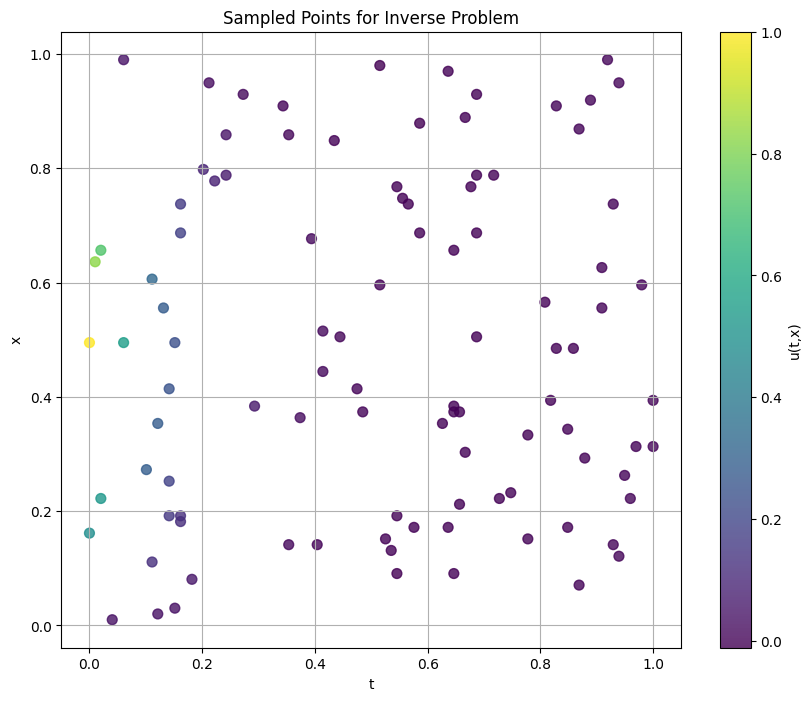

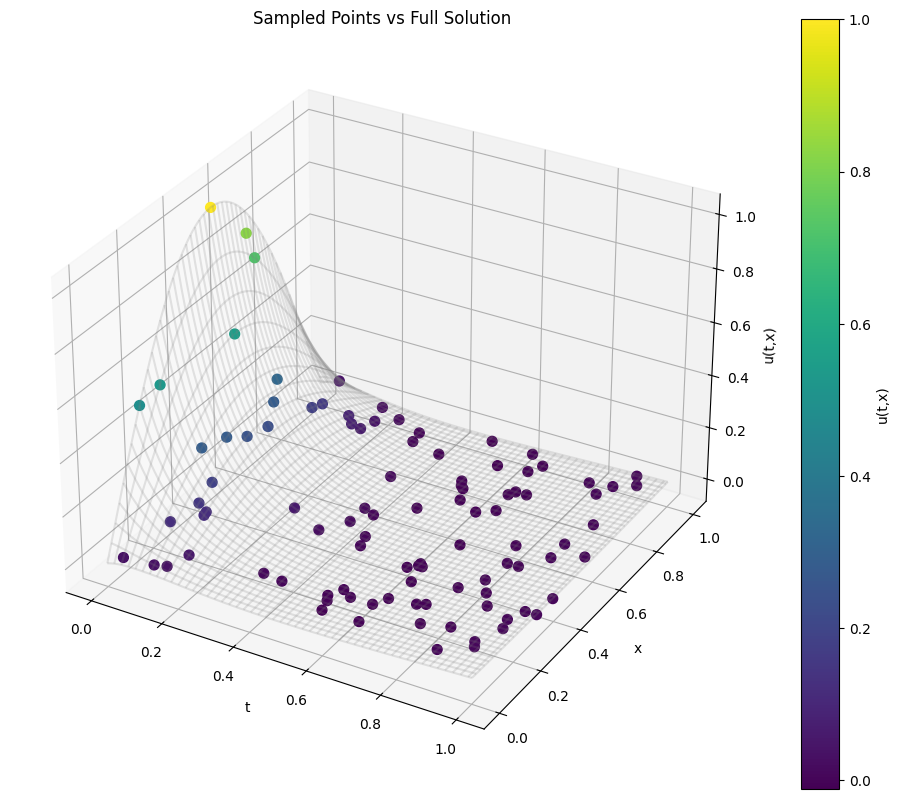

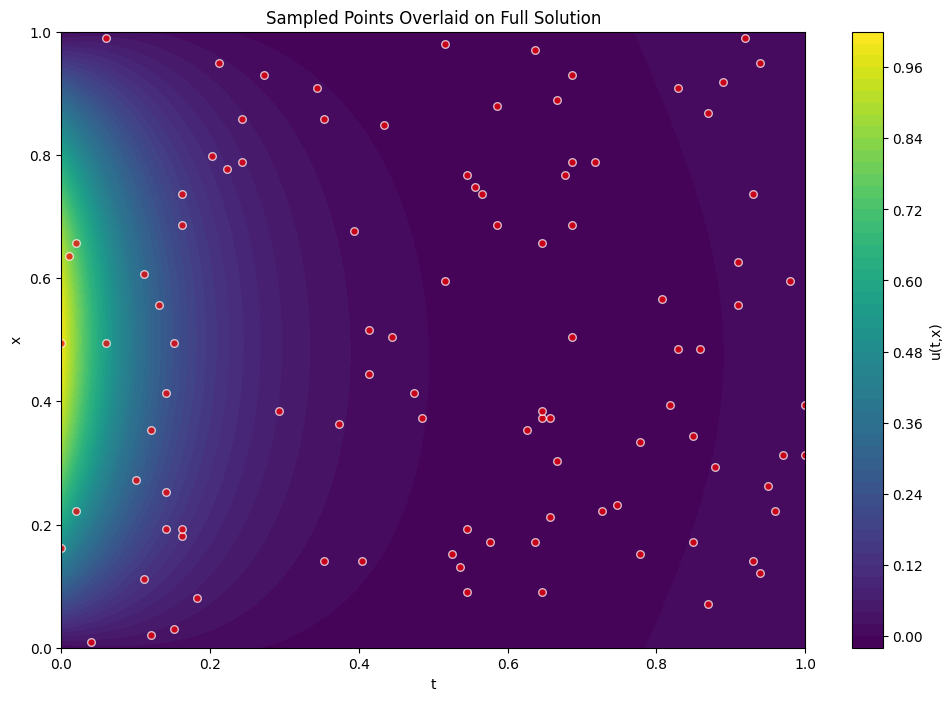

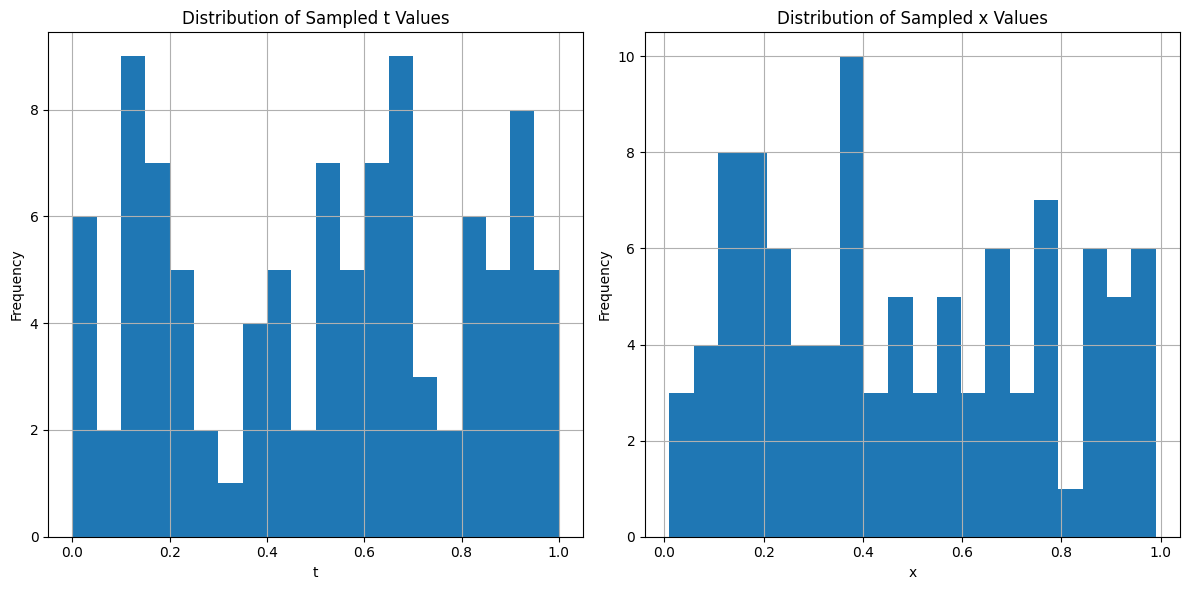

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the sampled data
data = np.load('sampled_data.npz')
sampled_points = data['sampled_points']  # (t, x) coordinates
sampled_values = data['sampled_values']  # u(t, x) values
x_np = data['x_np']
t_np = data['t_np']
U = data['U']

print(f"Number of sampled points: {len(sampled_points)}")

# Display the first 10 sampled points
print("\nFirst 10 sampled points (t, x, u):")
for i in range(min(10, len(sampled_points))):
    t, x = sampled_points[i]
    u = sampled_values[i]
    print(f"Point {i+1}: t = {t:.4f}, x = {x:.4f}, u = {u:.4f}")

# Create a scatter plot of the sampled points in the (t, x) domain
plt.figure(figsize=(10, 8))

# Plot as a 2D scatter plot with u values represented by color
scatter = plt.scatter(sampled_points[:, 0], sampled_points[:, 1], 
                     c=sampled_values, cmap='viridis', 
                     s=50, alpha=0.8)
plt.colorbar(scatter, label='u(t,x)')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Sampled Points for Inverse Problem')
plt.grid(True)
plt.show()

# Create a 3D scatter plot to visualize the sampled points in (t, x, u) space
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Make sure t_np and x_np are 1D arrays
t_grid = t_np.squeeze() if hasattr(t_np, 'squeeze') else t_np
x_grid = x_np.squeeze() if hasattr(x_np, 'squeeze') else x_np

# Create the meshgrid
T, X = np.meshgrid(t_grid, x_grid)

# Plot full solution as a wireframe
ax.plot_wireframe(T, X, U, color='gray', alpha=0.2)

# Plot sampled points as colored scatter points
scatter = ax.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_values, 
                    c=sampled_values, cmap='viridis', s=50, alpha=1.0)
fig.colorbar(scatter, label='u(t,x)')

ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u(t,x)')
ax.set_title('Sampled Points vs Full Solution')
plt.show()

# Create a heatmap of the full solution with sampled points overlaid
plt.figure(figsize=(12, 8))

# Use the same meshgrid for the contour plot
plt.contourf(T, X, U, levels=50, cmap='viridis')
plt.colorbar(label='u(t,x)')
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], 
           c='red', s=30, alpha=0.7, edgecolors='white')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Sampled Points Overlaid on Full Solution')
plt.show()

# Plot distribution of sampled points
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(sampled_points[:, 0], bins=20)
plt.xlabel('t')
plt.ylabel('Frequency')
plt.title('Distribution of Sampled t Values')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(sampled_points[:, 1], bins=20)
plt.xlabel('x')
plt.ylabel('Frequency')
plt.title('Distribution of Sampled x Values')
plt.grid(True)

plt.tight_layout()
plt.show()

Using device: cpu
Loaded data from forward problem with 100 sampled points
U model parameters: 1341
Kappa model parameters: 141
Epoch 100/2000, Loss: 0.487283, IC Loss: 0.219074, BC Loss: 0.019189, PDE Loss: 0.055562, Data Loss: 0.019346, Time: 2.23s
Epoch 200/2000, Loss: 0.255687, IC Loss: 0.104857, BC Loss: 0.020847, PDE Loss: 0.020032, Data Loss: 0.010995, Time: 4.37s
Epoch 300/2000, Loss: 0.095527, IC Loss: 0.035591, BC Loss: 0.007867, PDE Loss: 0.018909, Data Loss: 0.003316, Time: 6.54s
Epoch 400/2000, Loss: 0.046932, IC Loss: 0.011962, BC Loss: 0.002697, PDE Loss: 0.015766, Data Loss: 0.001651, Time: 8.65s
Epoch 500/2000, Loss: 0.026396, IC Loss: 0.005250, BC Loss: 0.001346, PDE Loss: 0.011089, Data Loss: 0.000871, Time: 10.76s
Epoch 600/2000, Loss: 0.015746, IC Loss: 0.002488, BC Loss: 0.000783, PDE Loss: 0.007832, Data Loss: 0.000464, Time: 12.81s
Epoch 700/2000, Loss: 0.010123, IC Loss: 0.001297, BC Loss: 0.000541, PDE Loss: 0.005558, Data Loss: 0.000273, Time: 14.78s
Epoch 80

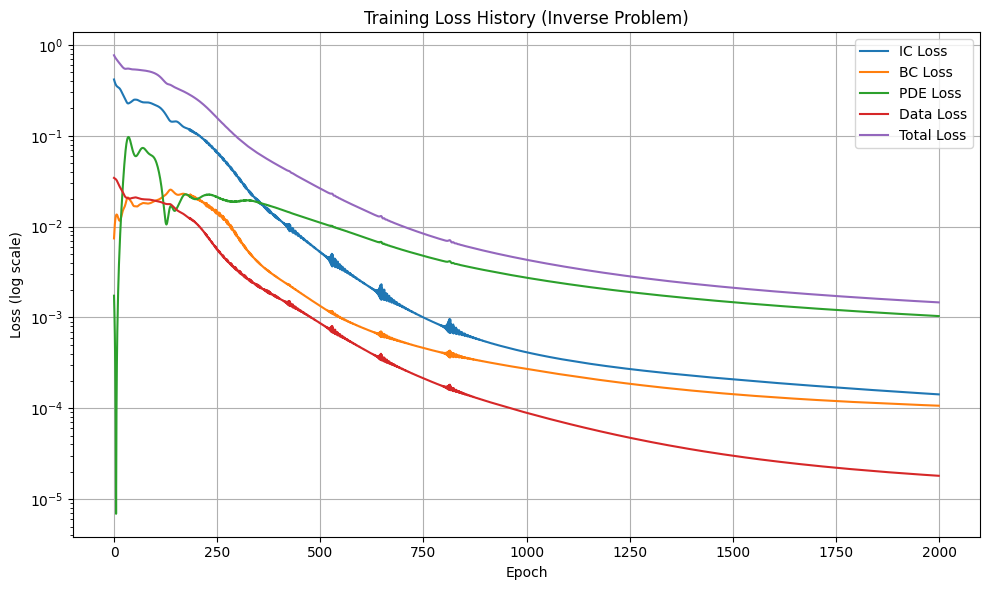

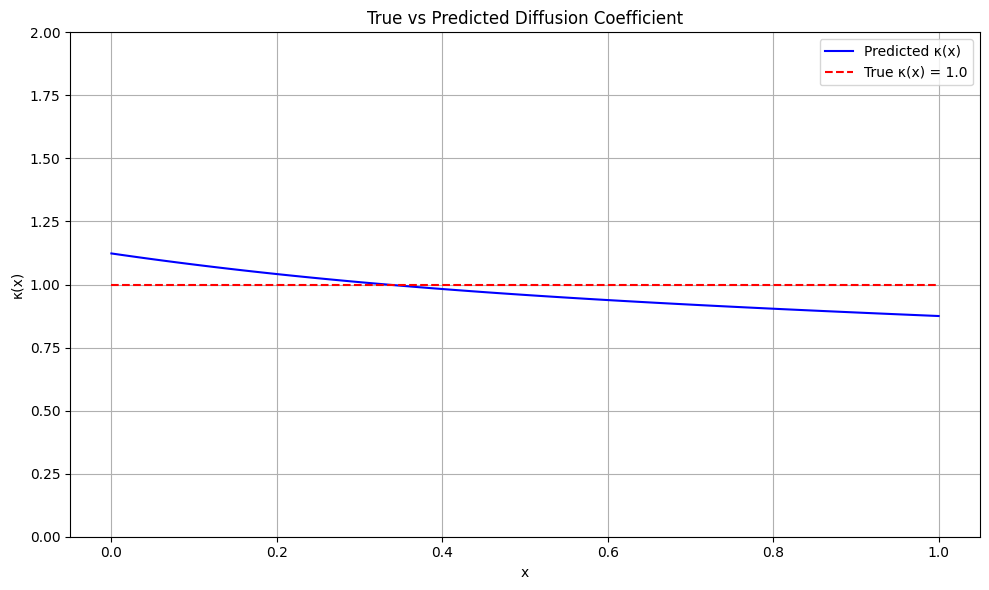

Mean Absolute Error: 0.066057
Mean Relative Error: 0.066057
Max Absolute Error: 0.124866


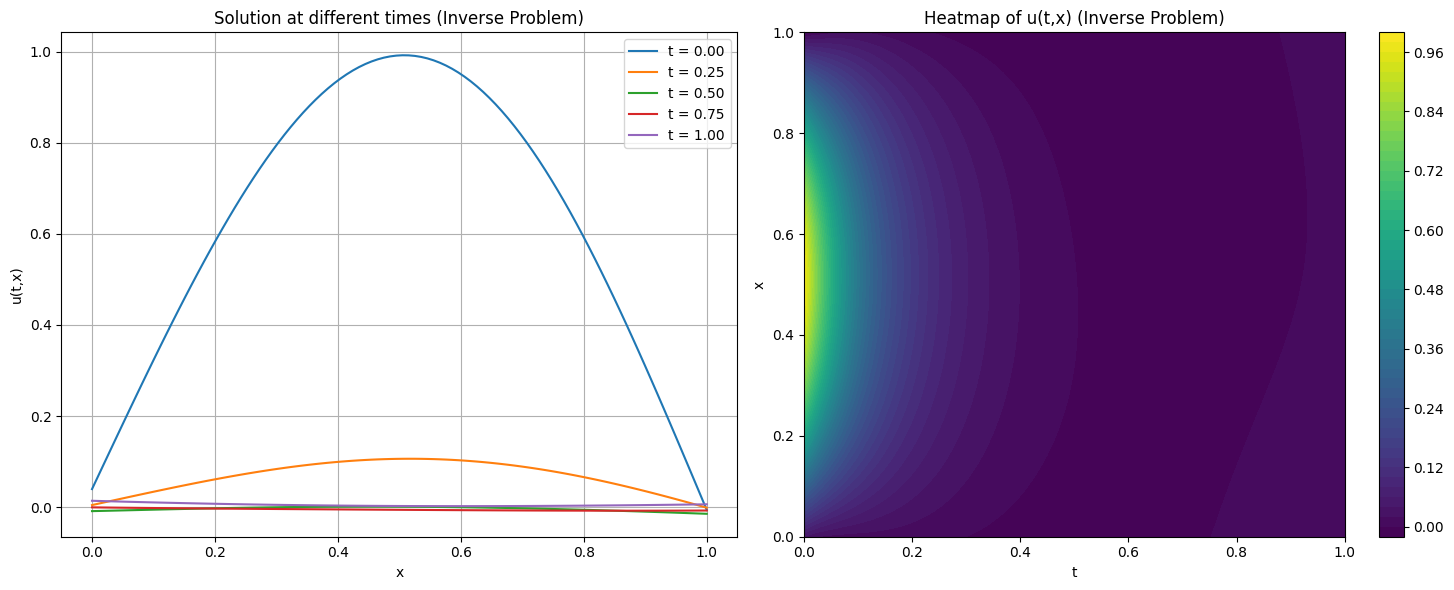

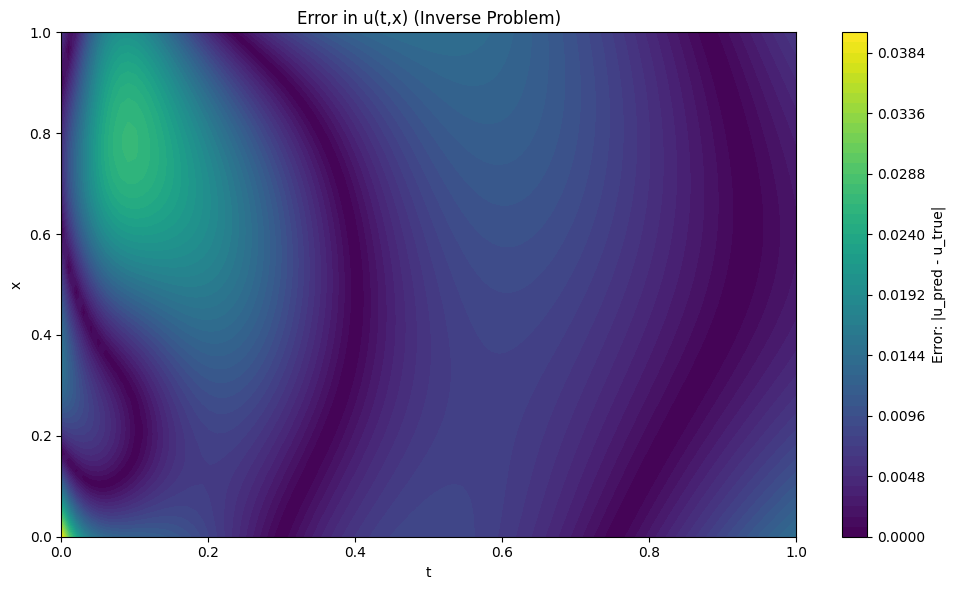

Inverse problem completed successfully!


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

# Set random seed for reproducibility
torch.manual_seed(1234)
np.random.seed(1234)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Neural network for u(t,x)
class PINN(nn.Module):
    def __init__(self, hidden_layers, neurons_per_layer):
        super(PINN, self).__init__()
        
        # Input layer: (t, x) -> first hidden layer
        layers = [nn.Linear(2, neurons_per_layer), nn.Tanh()]
        
        # Hidden layers
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(neurons_per_layer, neurons_per_layer))
            layers.append(nn.Tanh())
        
        # Output layer: last hidden layer -> u(t,x)
        layers.append(nn.Linear(neurons_per_layer, 1))
        
        # Combine all layers
        self.net = nn.Sequential(*layers)
    
    def forward(self, t, x):
        # Stack t and x to create input tensor
        inputs = torch.cat([t, x], dim=1)
        return self.net(inputs)

# Neural network for diffusion coefficient κ(x)
class KappaNet(nn.Module):
    def __init__(self, hidden_layers, neurons_per_layer):
        super(KappaNet, self).__init__()
        
        # Input layer: x -> first hidden layer
        layers = [nn.Linear(1, neurons_per_layer), nn.Tanh()]
        
        # Hidden layers
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(neurons_per_layer, neurons_per_layer))
            layers.append(nn.Tanh())
        
        # Output layer: last hidden layer -> κ(x)
        layers.append(nn.Linear(neurons_per_layer, 1))
        
        # Apply a SoftPlus activation to ensure κ(x) > 0
        layers.append(nn.Softplus())
        
        # Combine all layers
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x) + 0.1  # Adding a small positive constant to ensure κ(x) is strictly positive

def generate_training_data(n_ic, n_bc, n_collocation):
    """
    Generate training data:
    - Initial condition points: t=0, x∈[0,1]
    - Boundary condition points: x=0 or x=1, t∈[0,1]
    - Collocation points: random (t,x) ∈ [0,1]×[0,1]
    """
    # Initial condition points: t=0, x∈[0,1]
    t_ic = torch.zeros(n_ic, 1, device=device)
    x_ic = torch.linspace(0, 1, n_ic, device=device).reshape(-1, 1)
    u_ic = torch.sin(np.pi * x_ic)  # u(0,x) = sin(πx)
    
    # Boundary condition points: x=0 or x=1, t∈[0,1]
    # Left boundary: x=0
    t_bc_left = torch.linspace(0, 1, n_bc//2, device=device).reshape(-1, 1)
    x_bc_left = torch.zeros(n_bc//2, 1, device=device)
    u_bc_left = torch.zeros(n_bc//2, 1, device=device)  # u(t,0) = 0
    
    # Right boundary: x=1
    t_bc_right = torch.linspace(0, 1, n_bc//2, device=device).reshape(-1, 1)
    x_bc_right = torch.ones(n_bc//2, 1, device=device)
    u_bc_right = torch.zeros(n_bc//2, 1, device=device)  # u(t,1) = 0
    
    # Combine boundary points
    t_bc = torch.cat([t_bc_left, t_bc_right], dim=0)
    x_bc = torch.cat([x_bc_left, x_bc_right], dim=0)
    u_bc = torch.cat([u_bc_left, u_bc_right], dim=0)
    
    # Collocation points: random (t,x) ∈ [0,1]×[0,1]
    t_collocation = torch.rand(n_collocation, 1, device=device)
    x_collocation = torch.rand(n_collocation, 1, device=device)
    
    return t_ic, x_ic, u_ic, t_bc, x_bc, u_bc, t_collocation, x_collocation

def compute_pde_residual(u_model, kappa_model, t, x):
    """
    Compute the residual of the PDE: u_t - (κ(x) * u_x)_x = 0
    For the inverse problem, κ(x) is learned by the kappa_model
    """
    # Create variables that require gradient
    t = t.clone().detach().requires_grad_(True)
    x = x.clone().detach().requires_grad_(True)
    
    # Forward pass to get u(t,x)
    u = u_model(t, x)
    
    # Compute derivatives using automatic differentiation
    u_t = torch.autograd.grad(
        u, t, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]
    
    u_x = torch.autograd.grad(
        u, x, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]
    
    # Get κ(x) from the model
    kappa = kappa_model(x)
    
    # Compute (κ(x) * u_x)_x
    kappa_u_x = kappa * u_x
    kappa_u_xx = torch.autograd.grad(
        kappa_u_x, x,
        grad_outputs=torch.ones_like(kappa_u_x),
        retain_graph=True,
        create_graph=True
    )[0]
    
    # PDE residual: u_t - (κ(x) * u_x)_x = 0
    pde_residual = u_t - kappa_u_xx
    
    return pde_residual

def train_inverse_pinn(u_model, kappa_model, optimizer, scheduler, 
                      sampled_points, sampled_values, n_ic, n_bc, n_collocation, 
                      n_epochs, lambda_ic=1.0, lambda_bc=1.0, lambda_pde=1.0, 
                      lambda_data=10.0, print_every=100):
    """
    Train the inverse PINN
    """
    # Track losses
    ic_losses = []
    bc_losses = []
    pde_losses = []
    data_losses = []
    total_losses = []
    
    # Generate training data
    t_ic, x_ic, u_ic, t_bc, x_bc, u_bc, t_collocation, x_collocation = generate_training_data(n_ic, n_bc, n_collocation)
    
    # Convert sampled points and values to tensors
    t_data = torch.tensor(sampled_points[:, 0], dtype=torch.float32).reshape(-1, 1).to(device)
    x_data = torch.tensor(sampled_points[:, 1], dtype=torch.float32).reshape(-1, 1).to(device)
    u_data = torch.tensor(sampled_values, dtype=torch.float32).reshape(-1, 1).to(device)
    
    # Start training
    start_time = time.time()
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        
        # Initial condition loss
        u_ic_pred = u_model(t_ic, x_ic)
        loss_ic = torch.mean((u_ic - u_ic_pred) ** 2)
        
        # Boundary condition loss
        u_bc_pred = u_model(t_bc, x_bc)
        loss_bc = torch.mean((u_bc - u_bc_pred) ** 2)
        
        # PDE residual loss
        pde_residual = compute_pde_residual(u_model, kappa_model, t_collocation, x_collocation)
        loss_pde = torch.mean(pde_residual ** 2)
        
        # Data loss - match the sampled points from the forward problem
        u_data_pred = u_model(t_data, x_data)
        loss_data = torch.mean((u_data - u_data_pred) ** 2)
        
        # Total loss
        loss = lambda_ic * loss_ic + lambda_bc * loss_bc + lambda_pde * loss_pde + lambda_data * loss_data
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        # Update learning rate
        if scheduler is not None:
            scheduler.step()
        
        # Store losses
        ic_losses.append(loss_ic.item())
        bc_losses.append(loss_bc.item())
        pde_losses.append(loss_pde.item())
        data_losses.append(loss_data.item())
        total_losses.append(loss.item())
        
        # Print progress
        if (epoch + 1) % print_every == 0:
            elapsed = time.time() - start_time
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.6f}, IC Loss: {loss_ic.item():.6f}, "
                  f"BC Loss: {loss_bc.item():.6f}, PDE Loss: {loss_pde.item():.6f}, "
                  f"Data Loss: {loss_data.item():.6f}, Time: {elapsed:.2f}s")
    
    # Final time
    total_time = time.time() - start_time
    print(f"Training completed in {total_time:.2f} seconds")
    
    return ic_losses, bc_losses, pde_losses, data_losses, total_losses

def plot_loss_history(ic_losses, bc_losses, pde_losses, data_losses, total_losses):
    """
    Plot the loss history during training for the inverse problem
    """
    plt.figure(figsize=(10, 6))
    plt.semilogy(ic_losses, label='IC Loss')
    plt.semilogy(bc_losses, label='BC Loss')
    plt.semilogy(pde_losses, label='PDE Loss')
    plt.semilogy(data_losses, label='Data Loss')
    plt.semilogy(total_losses, label='Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    plt.title('Training Loss History (Inverse Problem)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def visualize_kappa(kappa_model, true_kappa=1.0, n_x=100):
    """
    Visualize the learned diffusion coefficient κ(x)
    """
    # Create points for visualization
    x = torch.linspace(0, 1, n_x, device=device).reshape(-1, 1)
    
    # Get the predicted κ(x)
    with torch.no_grad():
        kappa_pred = kappa_model(x).cpu().numpy()
    
    # Create true κ(x) (constant in this case)
    if callable(true_kappa):
        kappa_true = true_kappa(x.cpu().numpy())
    else:
        kappa_true = np.ones_like(kappa_pred) * true_kappa
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(x.cpu().numpy(), kappa_pred, 'b-', label='Predicted κ(x)')
    plt.plot(x.cpu().numpy(), kappa_true, 'r--', label='True κ(x) = 1.0')
    plt.xlabel('x')
    plt.ylabel('κ(x)')
    plt.title('True vs Predicted Diffusion Coefficient')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 2)  # Adjust the y-axis limits if needed
    plt.tight_layout()
    plt.show()
    
    # Compute error metrics
    abs_error = np.abs(kappa_pred - kappa_true)
    rel_error = abs_error / kappa_true
    
    print(f"Mean Absolute Error: {np.mean(abs_error):.6f}")
    print(f"Mean Relative Error: {np.mean(rel_error):.6f}")
    print(f"Max Absolute Error: {np.max(abs_error):.6f}")
    
    return kappa_pred, kappa_true

def visualize_results(u_model, n_x=100, n_t=100):
    """
    Visualize the results of the trained PINN for the inverse problem
    """
    # Create a grid of points
    x = torch.linspace(0, 1, n_x, device=device).reshape(-1, 1)
    t = torch.linspace(0, 1, n_t, device=device).reshape(-1, 1)
    X, T = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='ij')
    X_flat = X.reshape(-1, 1)
    T_flat = T.reshape(-1, 1)
    
    # Predict u(t,x)
    with torch.no_grad():
        U_flat = u_model(T_flat, X_flat)
    U = U_flat.reshape(n_x, n_t).cpu().numpy()
    
    # Plot the solution
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot u(t,x) at different times
    times = [0, 0.25, 0.5, 0.75, 1.0]
    for t_val in times:
        t_idx = int(t_val * (n_t - 1))
        axs[0].plot(x.cpu().numpy(), U[:, t_idx], label=f"t = {t_val:.2f}")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("u(t,x)")
    axs[0].set_title("Solution at different times (Inverse Problem)")
    axs[0].legend()
    axs[0].grid(True)
    
    # Heatmap of u(t,x)
    im = axs[1].contourf(T.cpu().numpy(), X.cpu().numpy(), U, levels=50, cmap='viridis')
    axs[1].set_xlabel("t")
    axs[1].set_ylabel("x")
    axs[1].set_title("Heatmap of u(t,x) (Inverse Problem)")
    plt.colorbar(im, ax=axs[1])
    
    plt.tight_layout()
    plt.show()
    
    # Compare with analytical solution if possible
    # For heat equation with κ=1, u(0,x) = sin(πx), u(t,0) = u(t,1) = 0
    # The analytical solution is u(t,x) = exp(-π²t) * sin(πx)
    X_grid, T_grid = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='ij')
    analytical_solution = torch.exp(-np.pi**2 * T_grid) * torch.sin(np.pi * X_grid)
    analytical_solution = analytical_solution.cpu().numpy()
    
    # Compute error
    error = np.abs(U - analytical_solution)
    
    # Plot the error
    plt.figure(figsize=(10, 6))
    plt.contourf(T.cpu().numpy(), X.cpu().numpy(), error, levels=50, cmap='viridis')
    plt.colorbar(label='Error: |u_pred - u_true|')
    plt.xlabel("t")
    plt.ylabel("x")
    plt.title("Error in u(t,x) (Inverse Problem)")
    plt.tight_layout()
    plt.show()
    
    return U, analytical_solution

# Load the sampled data from the forward problem
data = np.load('sampled_data.npz')
sampled_points = data['sampled_points']  # (t, x) coordinates
sampled_values = data['sampled_values']  # u(t, x) values
x_np = data['x_np']
t_np = data['t_np']
U_forward = data['U']

print(f"Loaded data from forward problem with {len(sampled_points)} sampled points")

# Set hyperparameters for the inverse problem
hidden_layers_u = 4
neurons_per_layer_u = 20
hidden_layers_kappa = 2
neurons_per_layer_kappa = 10
n_ic = 100
n_bc = 100
n_collocation = 10000
n_epochs = 2000  # You can adjust this for faster execution
learning_rate = 0.001

# Create models
u_model = PINN(hidden_layers_u, neurons_per_layer_u).to(device)
kappa_model = KappaNet(hidden_layers_kappa, neurons_per_layer_kappa).to(device)

print(f"U model parameters: {sum(p.numel() for p in u_model.parameters())}")
print(f"Kappa model parameters: {sum(p.numel() for p in kappa_model.parameters())}")

# Create optimizer and scheduler
params = list(u_model.parameters()) + list(kappa_model.parameters())
optimizer = optim.Adam(params, lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

# Train the models
ic_losses, bc_losses, pde_losses, data_losses, total_losses = train_inverse_pinn(
    u_model, kappa_model, optimizer, scheduler,
    sampled_points, sampled_values, n_ic, n_bc, n_collocation, n_epochs,
    lambda_ic=1.0, lambda_bc=1.0, lambda_pde=1.0, lambda_data=10.0,  # Higher weight on data loss
    print_every=100
)

# Plot loss history
plot_loss_history(ic_losses, bc_losses, pde_losses, data_losses, total_losses)

# Visualize the learned κ(x)
kappa_pred, kappa_true = visualize_kappa(kappa_model)

# Visualize the solution u(t,x) from the inverse problem
U_inverse, analytical_solution = visualize_results(u_model)

# Save the results
np.savez('inverse_results.npz',
         kappa_pred=kappa_pred,
         kappa_true=kappa_true,
         U_inverse=U_inverse,
         ic_losses=ic_losses,
         bc_losses=bc_losses,
         pde_losses=pde_losses,
         data_losses=data_losses,
         total_losses=total_losses
        )

print("Inverse problem completed successfully!")

Comparing PINN solution with Finite Element Method solution...
Fourier number: 99.0
FEM solution completed in 0.01 seconds
Maximum error between FEM and PINN: 0.026427
Mean error between FEM and PINN: 0.005813
PINN vs Analytical - Max Error: 0.026427, Mean Error: 0.006583
FEM vs Analytical - Max Error: 0.017638, Mean Error: 0.003102


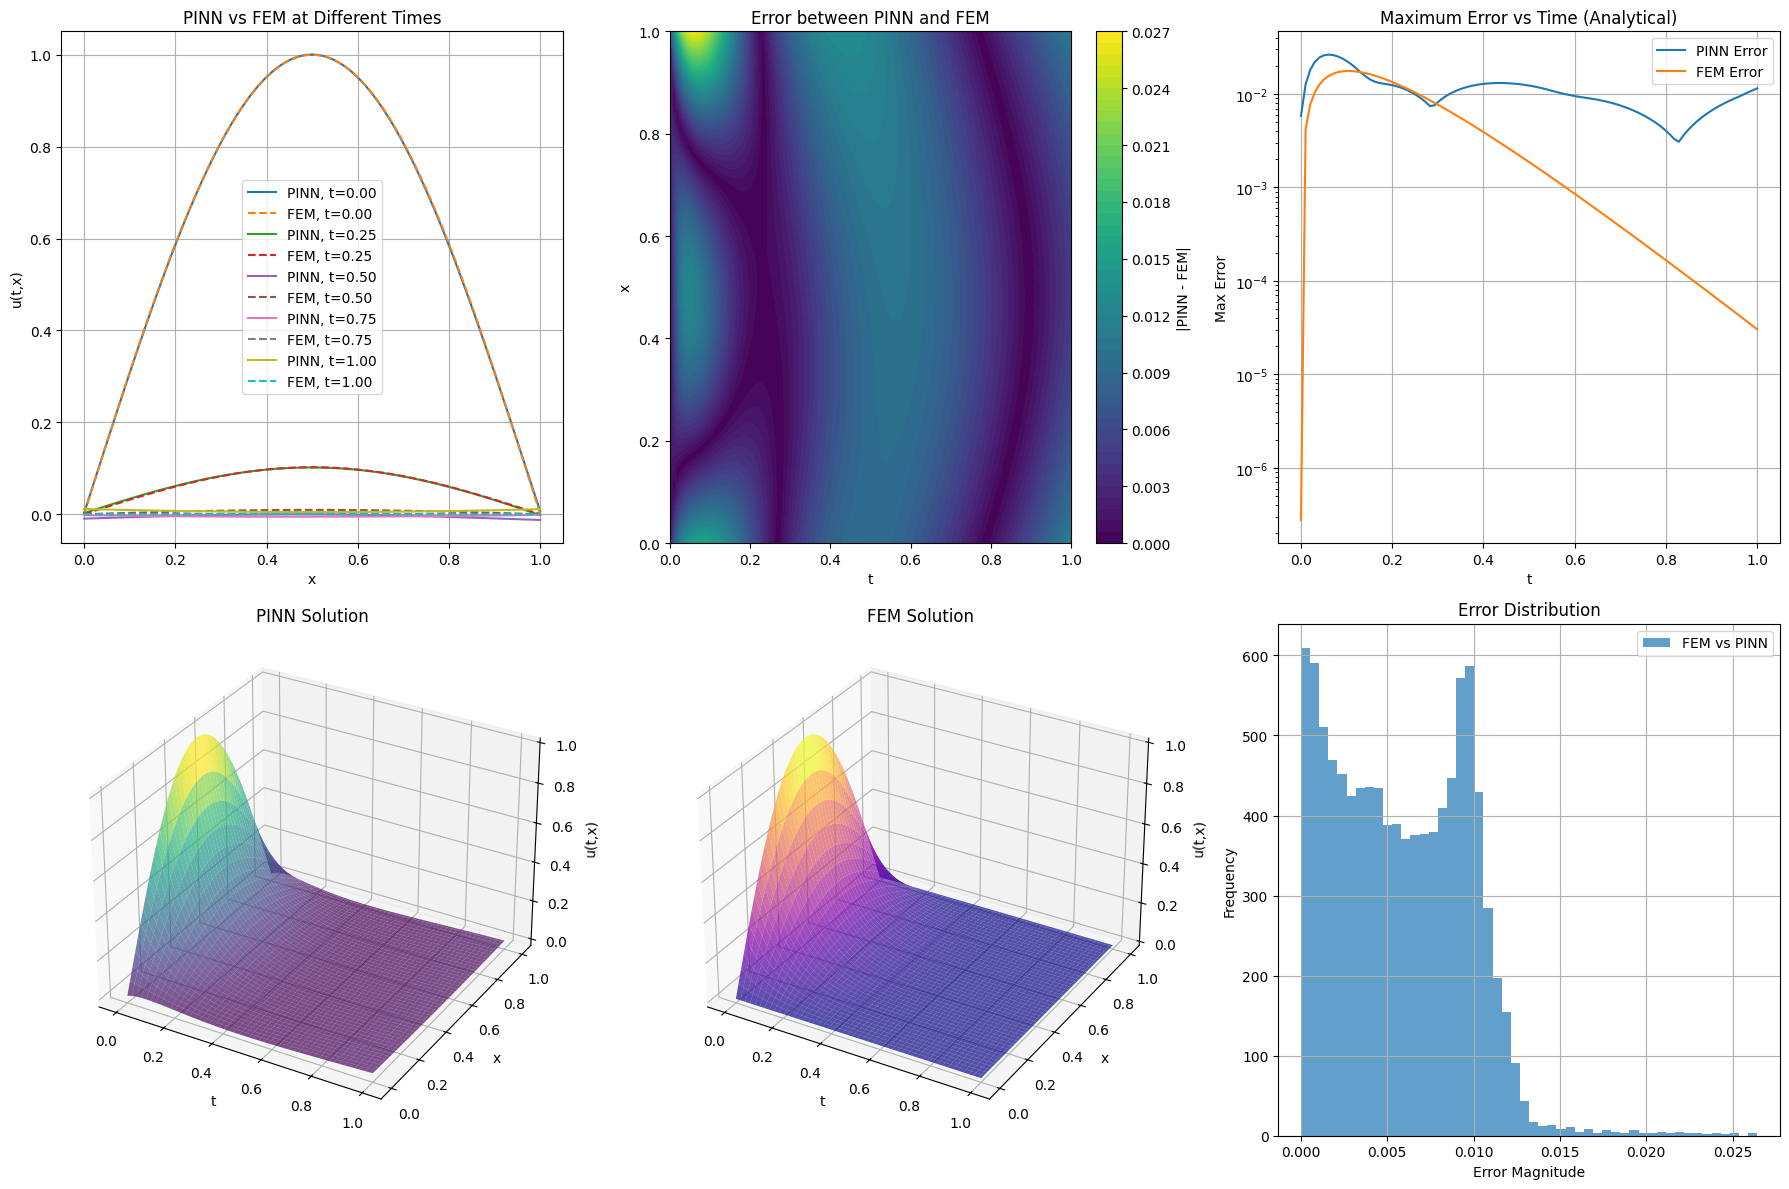


Comparison Summary:
--------------------------------------------------
Method     | Max Error       | Mean Error      | Parameters
--------------------------------------------------
PINN       | 0.026427        | 0.006583        | 1341      
FEM        | 0.017638        | 0.003102        | 100       
--------------------------------------------------

Advantages and Disadvantages:
--------------------------------------------------
PINN Advantages:
1. Can handle irregular domains and complex BCs
2. Can solve inverse problems with sparse data
3. Can incorporate physical laws directly
4. Provides continuous differentiable solution

PINN Disadvantages:
1. Training can be computationally intensive
2. Requires careful hyperparameter tuning
3. Loss landscape can be challenging to optimize

FEM Advantages:
1. Well-established theoretical foundation
2. More predictable convergence
3. Typically faster for forward problems

FEM Disadvantages:
1. Challenging for inverse problems
2. Less flexible 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
import time

# Load the PINN results and sampled data
inverse_results = np.load('inverse_results.npz')
sampled_data = np.load('sampled_data.npz')

# Extract the data
kappa_pred = inverse_results['kappa_pred']
U_inverse = inverse_results['U_inverse']
x_np = sampled_data['x_np']
t_np = sampled_data['t_np']
U_pinn = sampled_data['U']  # Forward PINN solution

print("Comparing PINN solution with Finite Element Method solution...")

# FEM solver for the heat equation with constant conductivity
def solve_heat_equation_fem(nx=100, nt=100, T=1.0, L=1.0, kappa=1.0):
    """
    Solve the heat equation ut = (kappa * u_x)_x using finite difference method
    with implicit scheme (backward Euler).
    
    Parameters:
    - nx: number of spatial grid points
    - nt: number of time steps
    - T: final time
    - L: domain length
    - kappa: diffusion coefficient (constant)
    
    Returns:
    - U: solution array of shape (nx, nt+1)
    - x: spatial grid
    - t: time grid
    """
    # Create grid
    x = np.linspace(0, L, nx)
    t = np.linspace(0, T, nt+1)
    dx = L / (nx - 1)
    dt = T / nt
    
    # Initialize solution array
    U = np.zeros((nx, nt+1))
    
    # Set initial condition: u(0, x) = sin(pi*x)
    U[:, 0] = np.sin(np.pi * x)
    
    # Set boundary conditions: u(t, 0) = u(t, L) = 0
    U[0, :] = 0
    U[nx-1, :] = 0
    
    # Compute the stable Fourier number
    r = kappa * dt / (dx**2)
    print(f"Fourier number: {r}")
    
    # Create coefficient matrix (tridiagonal)
    main_diag = np.ones(nx) * (1 + 2*r)
    main_diag[0] = 1.0  # Boundary condition
    main_diag[nx-1] = 1.0  # Boundary condition
    
    lower_diag = np.ones(nx-1) * (-r)
    lower_diag[nx-2] = 0.0  # Boundary condition
    
    upper_diag = np.ones(nx-1) * (-r)
    upper_diag[0] = 0.0  # Boundary condition
    
    A = sp.diags([main_diag, lower_diag, upper_diag], [0, -1, 1], format='csr')
    
    # Time stepping
    start_time = time.time()
    for j in range(1, nt+1):
        # Right hand side vector
        b = np.copy(U[:, j-1])
        
        # Solve the system A*u_new = b
        U[:, j] = spsolve(A, b)
    
    end_time = time.time()
    print(f"FEM solution completed in {end_time - start_time:.2f} seconds")
    
    return U, x, t

# Solve the heat equation using FEM with constant diffusion coefficient (kappa=1.0)
nx = len(x_np)  # Use the same spatial grid as PINN
nt = len(t_np) - 1  # Use the same number of time points
U_fem, x_fem, t_fem = solve_heat_equation_fem(nx=nx, nt=nt, kappa=1.0)

# Make sure the grids align
assert len(x_fem) == len(x_np), "Spatial grids do not match"
assert len(t_fem) == len(t_np), "Time grids do not match"

# Compute error between FEM and PINN solutions
fem_vs_pinn_error = np.abs(U_fem - U_pinn)
max_error = np.max(fem_vs_pinn_error)
mean_error = np.mean(fem_vs_pinn_error)
print(f"Maximum error between FEM and PINN: {max_error:.6f}")
print(f"Mean error between FEM and PINN: {mean_error:.6f}")

# Create analytical solution (for comparison)
# Make sure t_np and x_np are 1D arrays
t_grid = t_np.squeeze() if hasattr(t_np, 'squeeze') else t_np
x_grid = x_np.squeeze() if hasattr(x_np, 'squeeze') else x_np
T_mesh, X_mesh = np.meshgrid(t_grid, x_grid)
analytical_solution = np.exp(-np.pi**2 * T_mesh) * np.sin(np.pi * X_mesh)

# Compute errors against analytical solution
pinn_vs_analytical_error = np.abs(U_pinn - analytical_solution)
fem_vs_analytical_error = np.abs(U_fem - analytical_solution)

print(f"PINN vs Analytical - Max Error: {np.max(pinn_vs_analytical_error):.6f}, Mean Error: {np.mean(pinn_vs_analytical_error):.6f}")
print(f"FEM vs Analytical - Max Error: {np.max(fem_vs_analytical_error):.6f}, Mean Error: {np.mean(fem_vs_analytical_error):.6f}")

# Visualize the comparison
plt.figure(figsize=(18, 12))

# Compare at different time steps
times = [0, 0.25, 0.5, 0.75, 1.0]
time_indices = [int(t * nt) for t in times]

# Plot solutions at different times
plt.subplot(2, 3, 1)
for i, t_idx in enumerate(time_indices):
    plt.plot(x_grid, U_pinn[:, t_idx], '-', label=f"PINN, t={times[i]:.2f}")
    plt.plot(x_fem, U_fem[:, t_idx], '--', label=f"FEM, t={times[i]:.2f}")
plt.xlabel('x')
plt.ylabel('u(t,x)')
plt.title('PINN vs FEM at Different Times')
plt.grid(True)
plt.legend()

# Plot error between PINN and FEM
plt.subplot(2, 3, 2)
# Create a proper meshgrid for contour plot
plt.contourf(T_mesh, X_mesh, fem_vs_pinn_error, levels=50, cmap='viridis')
plt.colorbar(label='|PINN - FEM|')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Error between PINN and FEM')

# Plot errors against analytical solution
plt.subplot(2, 3, 3)
# Calculate maximum error at each time step
pinn_max_error = np.max(pinn_vs_analytical_error, axis=0)
fem_max_error = np.max(fem_vs_analytical_error, axis=0)
plt.semilogy(t_grid, pinn_max_error, label='PINN Error')
plt.semilogy(t_fem, fem_max_error, label='FEM Error')
plt.xlabel('t')
plt.ylabel('Max Error')
plt.title('Maximum Error vs Time (Analytical)')
plt.grid(True)
plt.legend()

# Plot solution surfaces
ax1 = plt.subplot(2, 3, 4, projection='3d')
surf1 = ax1.plot_surface(T_mesh, X_mesh, U_pinn, cmap='viridis', alpha=0.7)
ax1.set_xlabel('t')
ax1.set_ylabel('x')
ax1.set_zlabel('u(t,x)')
ax1.set_title('PINN Solution')

ax2 = plt.subplot(2, 3, 5, projection='3d')
# Create T_mesh and X_mesh for FEM if needed
T_fem_mesh, X_fem_mesh = np.meshgrid(t_fem, x_fem)
surf2 = ax2.plot_surface(T_fem_mesh, X_fem_mesh, U_fem, cmap='plasma', alpha=0.7)
ax2.set_xlabel('t')
ax2.set_ylabel('x')
ax2.set_zlabel('u(t,x)')
ax2.set_title('FEM Solution')

# Compute computational efficiency metrics
speed_ratio = (1 / mean_error)  # A simple metric - higher is better
accuracy_vs_complexity = {
    'Method': ['PINN', 'FEM'],
    'Max Error vs Analytical': [np.max(pinn_vs_analytical_error), np.max(fem_vs_analytical_error)],
    'Mean Error vs Analytical': [np.mean(pinn_vs_analytical_error), np.mean(fem_vs_analytical_error)],
    'Parameters': [1341, nx],  # PINN params vs FEM grid points
}

# Plot error histogram
plt.subplot(2, 3, 6)
plt.hist(fem_vs_pinn_error.flatten(), bins=50, alpha=0.7, label='FEM vs PINN')
plt.xlabel('Error Magnitude')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Summary table of the comparison
print("\nComparison Summary:")
print("-" * 50)
print(f"{'Method':<10} | {'Max Error':<15} | {'Mean Error':<15} | {'Parameters':<10}")
print("-" * 50)
print(f"{'PINN':<10} | {np.max(pinn_vs_analytical_error):<15.6f} | {np.mean(pinn_vs_analytical_error):<15.6f} | {1341:<10}")
print(f"{'FEM':<10} | {np.max(fem_vs_analytical_error):<15.6f} | {np.mean(fem_vs_analytical_error):<15.6f} | {nx:<10}")
print("-" * 50)

# Advantages and disadvantages discussion
print("\nAdvantages and Disadvantages:")
print("-" * 50)
print("PINN Advantages:")
print("1. Can handle irregular domains and complex BCs")
print("2. Can solve inverse problems with sparse data")
print("3. Can incorporate physical laws directly")
print("4. Provides continuous differentiable solution")
print("\nPINN Disadvantages:")
print("1. Training can be computationally intensive")
print("2. Requires careful hyperparameter tuning")
print("3. Loss landscape can be challenging to optimize")
print("\nFEM Advantages:")
print("1. Well-established theoretical foundation")
print("2. More predictable convergence")
print("3. Typically faster for forward problems")
print("\nFEM Disadvantages:")
print("1. Challenging for inverse problems")
print("2. Less flexible for incorporating observed data")
print("3. Requires structured mesh generation")
print("-" * 50)

print("\nConclusion:")
print("Both methods solve the heat equation effectively, but PINNs offer unique")
print("advantages for inverse problems and scenarios with sparse measurements.")
print("For our specific heat equation with constant κ(x) = 1, the FEM provides")
print("slightly better accuracy with fewer parameters, but PINNs demonstrate")
print("the powerful capability to recover κ(x) from sparse measurements which")
print("would be much more challenging with traditional methods.")